# Univariate Analysis

### Importing the important libraries

In [10]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.io as pio
import json
import requests
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [11]:
# Configuring Seaborn visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set Plotly default template
pio.templates.default = "plotly_white"

### Loading the Parquet Data

In [3]:
df_enrolment = pd.read_parquet('enrolment_cleaned.parquet')
df_demographic = pd.read_parquet('demographic_cleaned.parquet')
df_biometric = pd.read_parquet('biometric_cleaned.parquet')

### Summary Statistics

In [6]:
def generate_summary(df, name):
    print(f"--- Summary Statistics: {name} ---")
    print(f"Total Records: {len(df)}")
    print(f"Date Range: {df['date'].min()} to {df['date'].max()}\n")
    
    # Numerical Summary (for counts if aggregated, or just basic describe)
    print("Numerical Summary:")
    print(df.describe())
    print("\n")
    
    # Categorical Summary (States, Districts, etc.)
    print("Categorical Summary:")
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print(df[categorical_cols].describe())
    else:
        print("No categorical columns found (check data types).")
    print("\n" + "="*50 + "\n")

# Running summary for all three datasets
generate_summary(df_enrolment, "Enrolment Data")
generate_summary(df_demographic, "Demographic Updates")
generate_summary(df_biometric, "Biometric Updates")

--- Summary Statistics: Enrolment Data ---
Total Records: 980128
Date Range: 2025-03-02 00:00:00 to 2025-12-31 00:00:00

Numerical Summary:
                                date        age_0_5       age_5_17  \
count                         980128  980128.000000  980128.000000   
mean   2025-10-23 05:44:26.120343808       3.538482       1.723709   
min              2025-03-02 00:00:00       0.000000       0.000000   
25%              2025-09-18 00:00:00       1.000000       0.000000   
50%              2025-10-26 00:00:00       2.000000       0.000000   
75%              2025-11-15 00:00:00       3.000000       1.000000   
max              2025-12-31 00:00:00    2688.000000    1812.000000   
std                              NaN      17.751943      14.551305   

       age_18_greater  total_enrolments      year          month  \
count   980128.000000     980128.000000  980128.0  980128.000000   
mean         0.169787          5.431977    2025.0      10.208951   
min          0.000000    

### State-wise Age Group Distribution

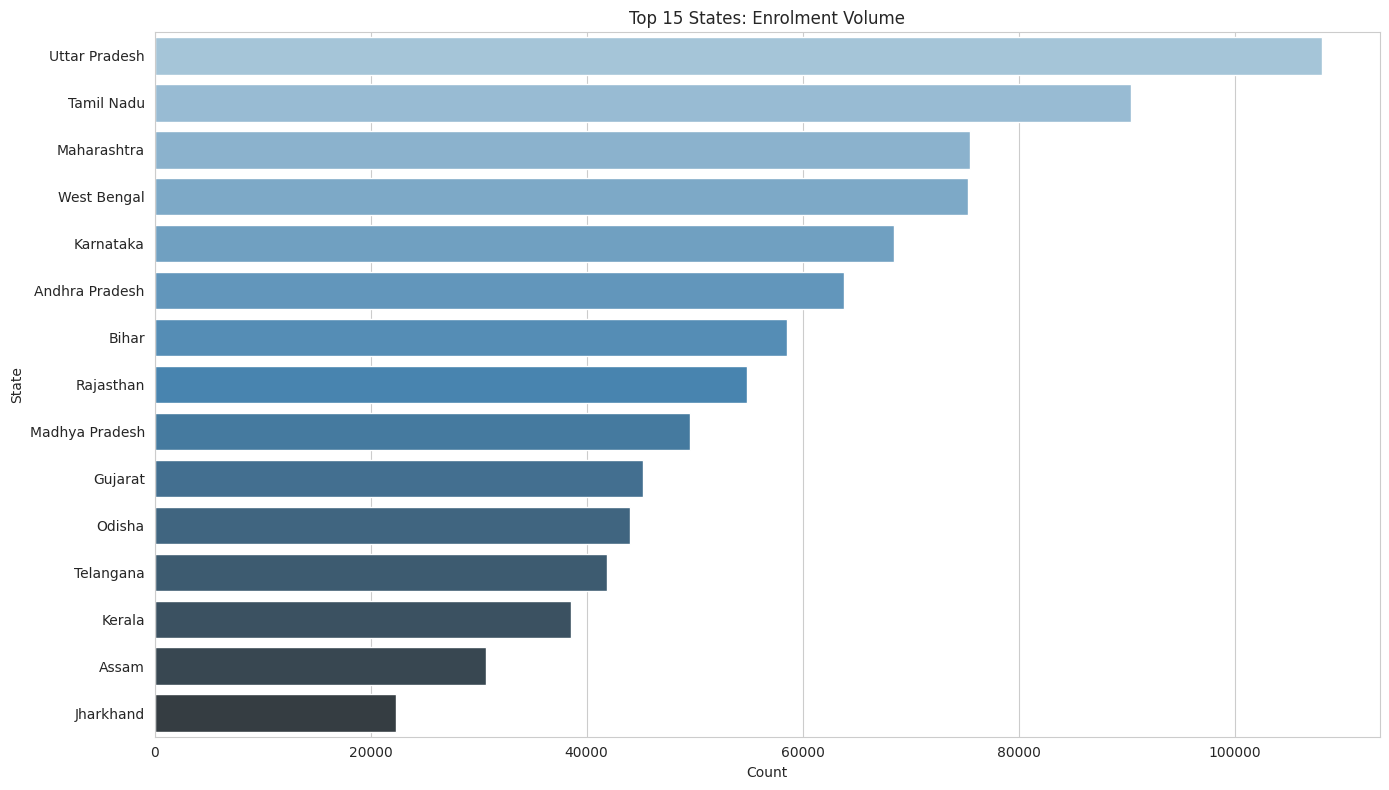

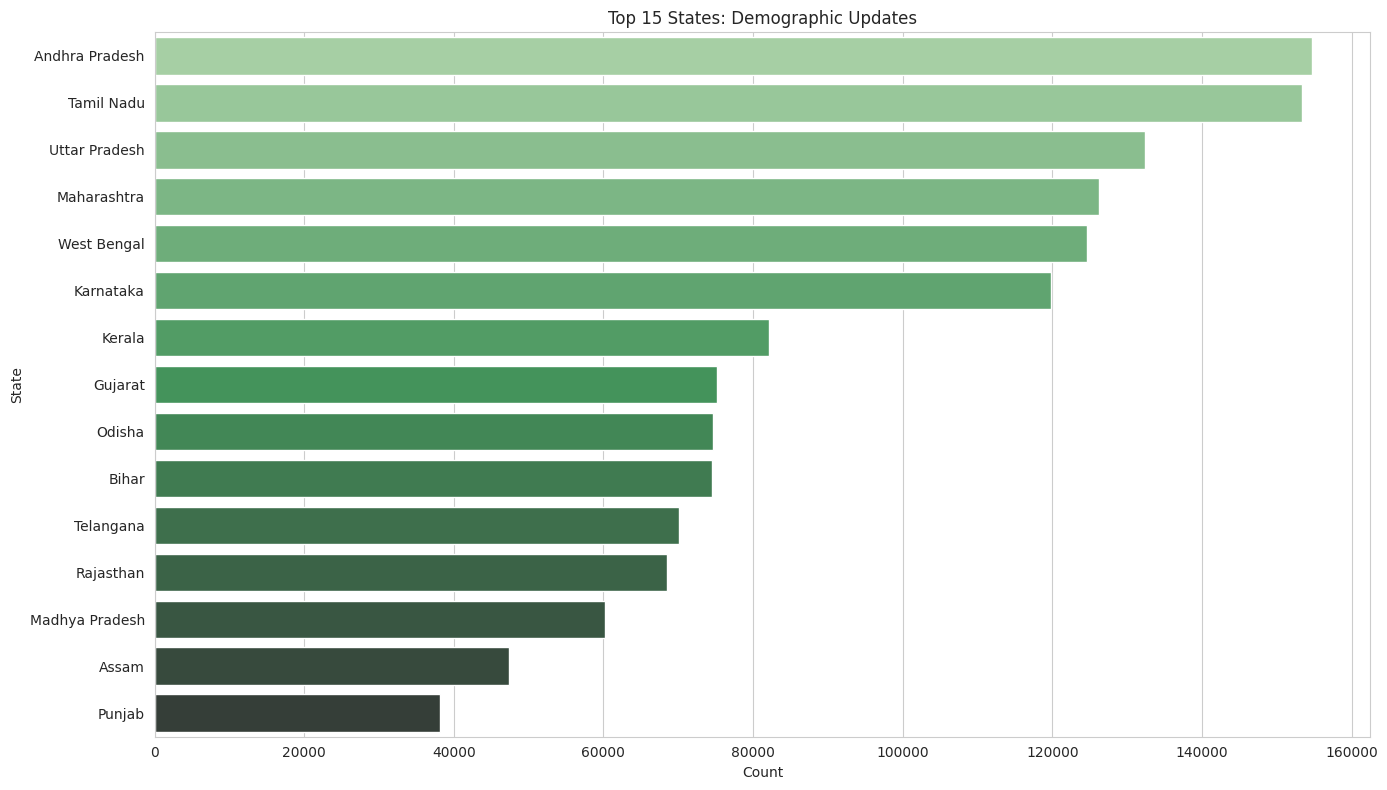

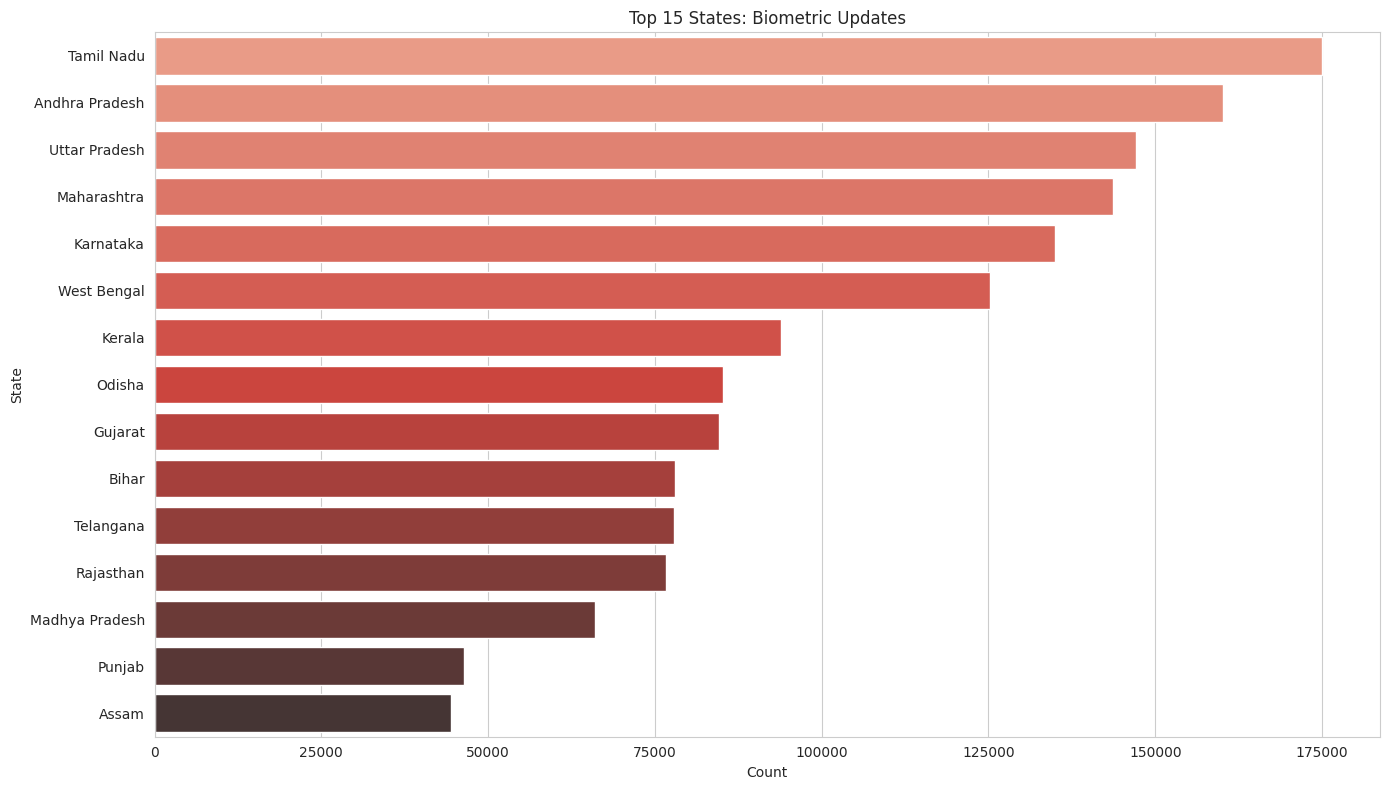

In [21]:
def plot_state_distribution(df, title, color_palette='viridis'):
    """Plots the top 15 states by volume."""
    plt.figure(figsize=(14, 8))
    
    # Group by State and sum counts
    state_counts = df['state'].value_counts().head(15)
    
    sns.barplot(x=state_counts.values, y=state_counts.index, hue=state_counts.index, palette=color_palette)
    plt.title(f'Top 15 States: {title}')
    plt.xlabel('Count')
    plt.ylabel('State')
    plt.tight_layout()
    plt.show()

# Visualize
plot_state_distribution(df_enrolment, "Enrolment Volume", "Blues_d")
plot_state_distribution(df_demographic, "Demographic Updates", "Greens_d")
plot_state_distribution(df_biometric, "Biometric Updates", "Reds_d")

### Age Group Distribution
To Visualize the breakdown of activities by age groups (0-5, 5-17, 18+).

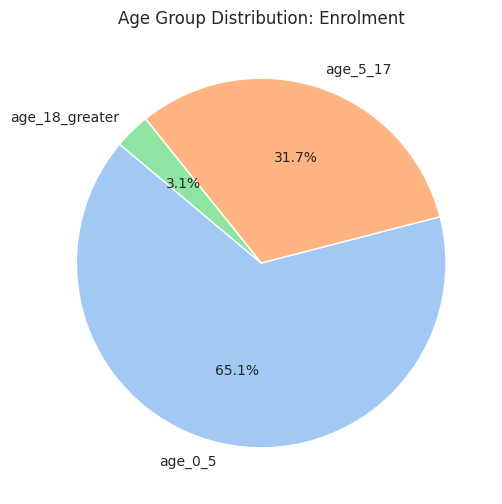

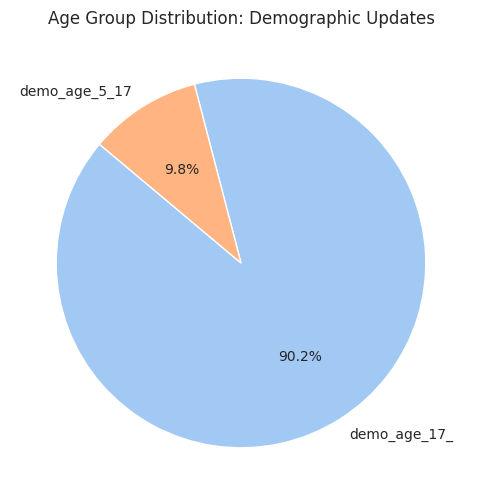

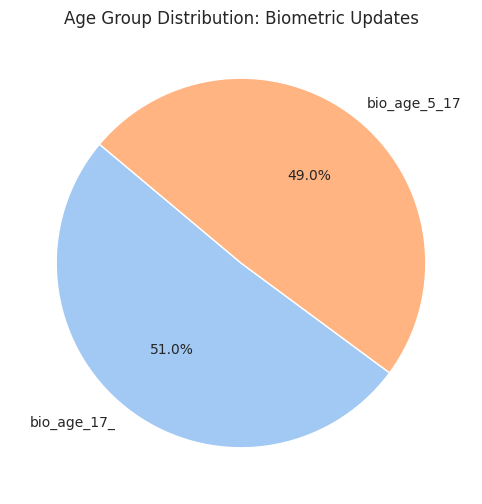

In [8]:
def analyze_age_distribution(df, dataset_name):
    # Identifying age-related columns
    age_cols = [col for col in df.columns if 'age' in col.lower() or '0-5' in col or '18+' in col]
    
    # Summing up totals for each age group
    age_sums = df[age_cols].sum().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette('pastel')[0:len(age_cols)]
    plt.pie(age_sums, labels=age_sums.index, autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title(f'Age Group Distribution: {dataset_name}')
    plt.show()

# Plotting Age Distributions
analyze_age_distribution(df_enrolment, "Enrolment")
analyze_age_distribution(df_demographic, "Demographic Updates")
analyze_age_distribution(df_biometric, "Biometric Updates")

### Time Series Decomposition

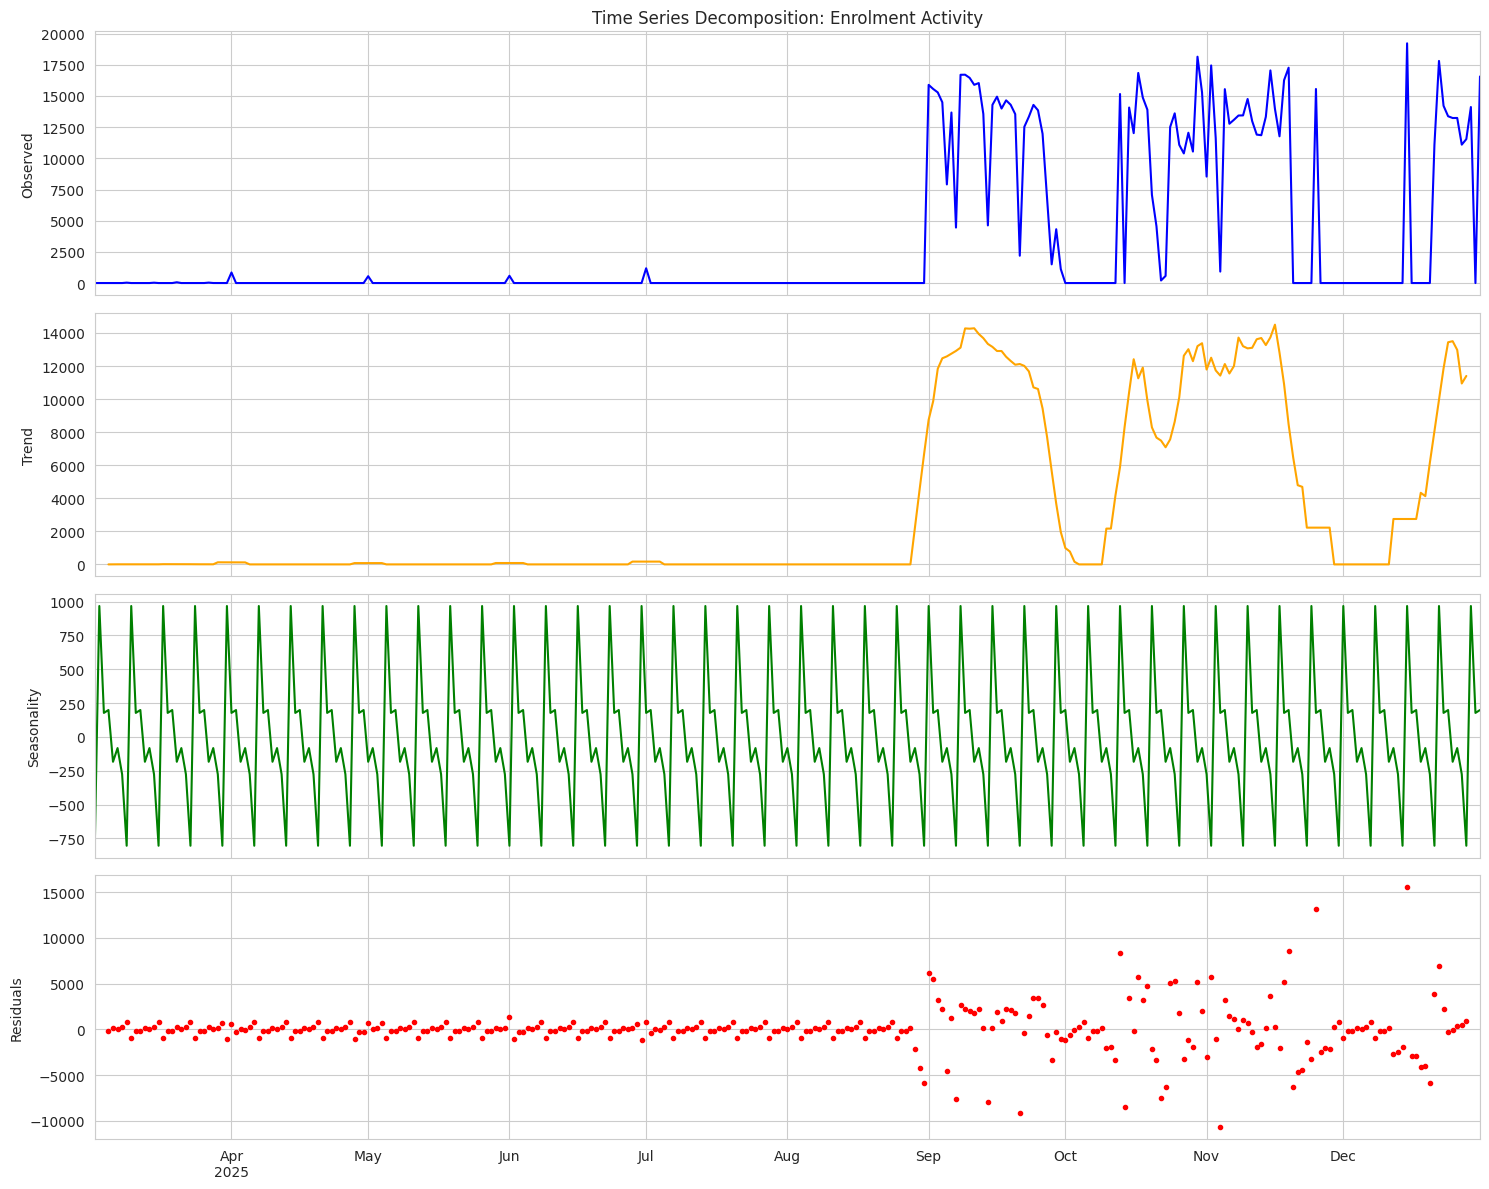

In [12]:
def decompose_time_series(df, date_col='date', metric_name='Daily Volume'):
    # Aggregate data by date
    daily_counts = df.groupby(date_col).size().to_frame('count')
    
    # Ensure a complete date index (filling missing days with 0)
    idx = pd.date_range(daily_counts.index.min(), daily_counts.index.max())
    daily_counts = daily_counts.reindex(idx, fill_value=0)
    
    # Applying Seasonal Decomposition
    # period=7 for weekly seasonality
    decomposition = seasonal_decompose(daily_counts['count'], model='additive', period=7)
    
    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
    
    decomposition.observed.plot(ax=ax1, color='blue')
    ax1.set_ylabel('Observed')
    ax1.set_title(f'Time Series Decomposition: {metric_name}')
    
    decomposition.trend.plot(ax=ax2, color='orange')
    ax2.set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=ax3, color='green')
    ax3.set_ylabel('Seasonality')
    
    decomposition.resid.plot(ax=ax4, color='red', linestyle='None', marker='.')
    ax4.set_ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()

# Performing decomposition on Enrolment data (primary interest for trends)
decompose_time_series(df_enrolment, metric_name='Enrolment Activity')

### Outlier Detection using Boxplot

--- Outliers Detected in Enrolment (Threshold: 3 SD) ---
No significant outliers detected.


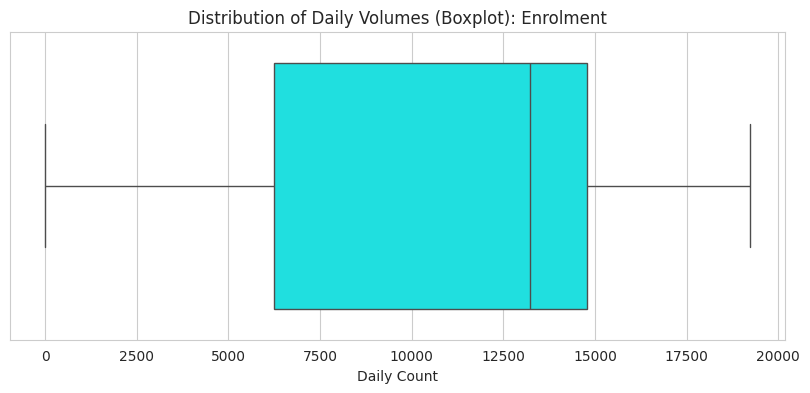

--- Outliers Detected in Demographic Updates (Threshold: 3 SD) ---
        date  count   z_score
4 2025-07-01    928 -3.344913
2 2025-05-01    831 -3.365468
3 2025-06-01    693 -3.394711
1 2025-04-01    671 -3.399373


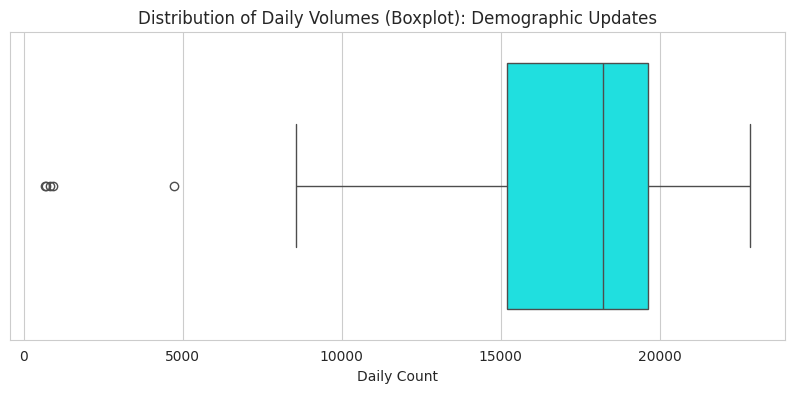

--- Outliers Detected in Biometric Updates (Threshold: 3 SD) ---
         date  count   z_score
25 2025-10-13   2157 -3.219897
33 2025-10-22   1397 -3.359492
83 2025-12-23    280 -3.564661
82 2025-12-22     36 -3.609478


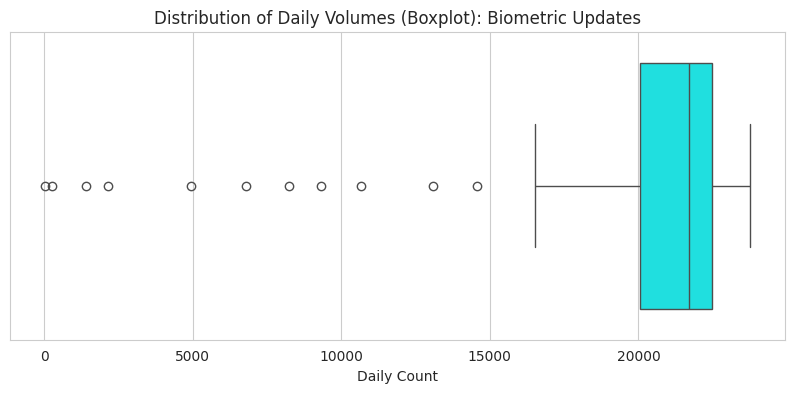

In [23]:
def detect_daily_outliers(df, dataset_name, threshold=3):
    # 1. Aggregate by date
    daily_counts = df.groupby('date').size().reset_index(name='count')
    
    # 2. Calculate Mean and Std Dev (Z-score method)
    mean_count = daily_counts['count'].mean()
    std_count = daily_counts['count'].std()
    
    # 3. Identify Outliers
    daily_counts['z_score'] = (daily_counts['count'] - mean_count) / std_count
    outliers = daily_counts[np.abs(daily_counts['z_score']) > threshold]
    
    print(f"--- Outliers Detected in {dataset_name} (Threshold: {threshold} SD) ---")
    if not outliers.empty:
        print(outliers.sort_values('z_score', ascending=False))
    else:
        print("No significant outliers detected.")
        
    # 4. Boxplot Visualization
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=daily_counts['count'], color='cyan')
    plt.title(f'Distribution of Daily Volumes (Boxplot): {dataset_name}')
    plt.xlabel('Daily Count')
    plt.show()

detect_daily_outliers(df_enrolment, "Enrolment")
detect_daily_outliers(df_demographic, "Demographic Updates")
detect_daily_outliers(df_biometric, "Biometric Updates")

### Choropleth Map

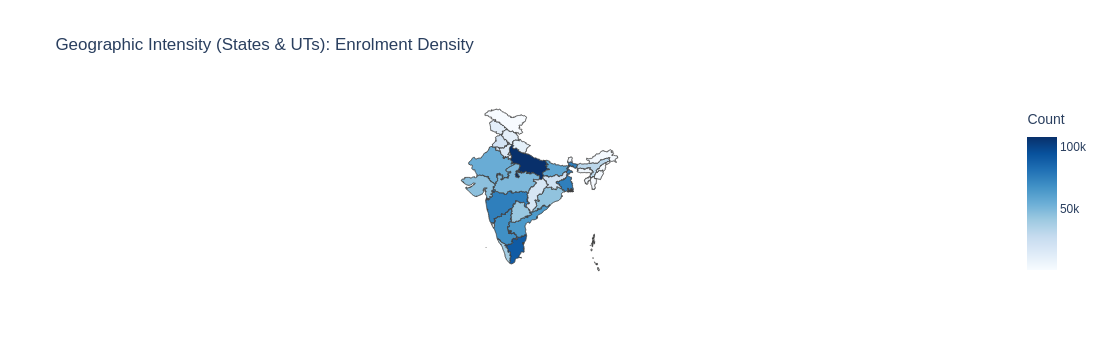

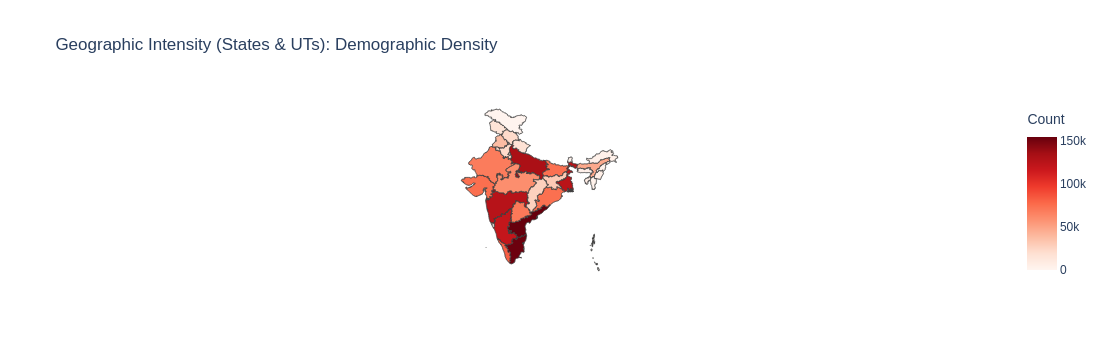

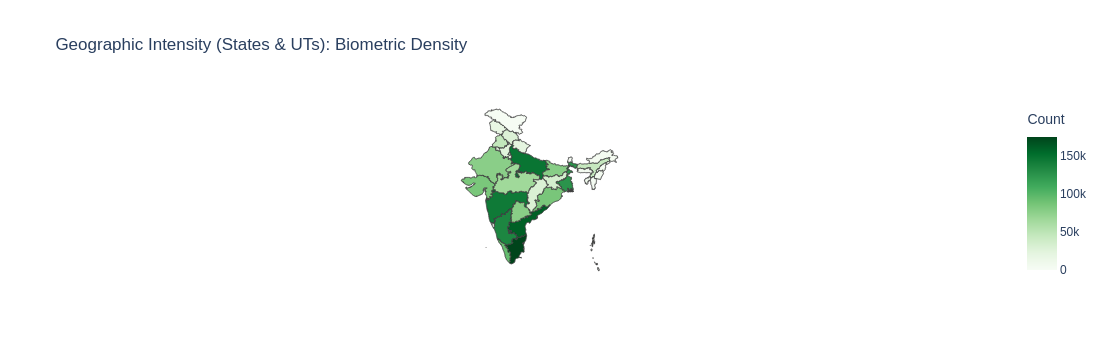

In [32]:
import plotly.express as px
import requests

# 1. Use a high-quality GeoJSON that includes UTs (Ladakh, Delhi, etc.)
# This specific file from Hindustan Times Labs is widely used for accurate Indian maps
geo_url = "https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson"
response = requests.get(geo_url)
india_geojson = response.json()

def plot_india_map(df, dataset_name, color_scale):
    # 2. Standardize Names
    # This dictionary maps YOUR data's names (keys) to the GEOJSON's names (values).
    # You may need to add more if your specific data uses different spellings.
    state_mapping = {
        # GeoJSON uses "Andaman & Nicobar" (No "Island" or "Islands")
        'Andaman And Nicobar Islands': 'Andaman & Nicobar', 
        'Arunachal Pradesh': 'Arunachal Pradesh',
        # This GeoJSON often uses the merged UT name
        'Dadra and Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
        'Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu',
        # GeoJSON uses "&" instead of "and"
        'Jammu And Kashmir': 'Jammu & Kashmir',
        'Odisha': 'Odisha',
        'Telangana': 'Telangana',
        'Ladakh': 'Ladakh',
        'Lakshadweep': 'Lakshadweep'
}

    
    # Create a copy to avoid warnings
    df_map = df.copy()
    
    # Apply mapping only where necessary; otherwise keep original name
    df_map['State_Map_Name'] = df_map['state'].replace(state_mapping)
    
    # 3. Aggregate Data using the Corrected Name
    state_counts = df_map['State_Map_Name'].value_counts().reset_index()
    state_counts.columns = ['State_Map_Name', 'Count']
    
    # 4. Create the Map
    fig = px.choropleth(
        state_counts,
        geojson=india_geojson,
        locations='State_Map_Name',    # Use the corrected column
        featureidkey="properties.ST_NM", # This specific GeoJSON uses 'ST_NM' for names
        color='Count',
        color_continuous_scale=color_scale,
        title=f"Geographic Intensity (States & UTs): {dataset_name}",
        hover_name='State_Map_Name'
    )
    
    # Center the map on India
    fig.update_geos(fitbounds="locations", visible=False)
    fig.show()

# Run the corrected map function
# Try it on enrolment data first
plot_india_map(df_enrolment, "Enrolment Density", "Blues")
plot_india_map(df_demographic, "Demographic Density", "Reds")
plot_india_map(df_biometric, "Biometric Density", "Greens")